In [1]:
# Import libraries
import sys
sys.path.append('../src')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

from anomaly_detector import AnomalyDetector
from visualization import AadhaarVisualizer

# Settings
pd.set_option('display.max_columns', None)
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)

print("✓ Libraries imported")

✓ Libraries imported


## 1. Load Processed Data

In [2]:
print("Loading processed datasets...")

enrolment_df = pd.read_parquet('../outputs/enrolment_processed.parquet')
demographic_df = pd.read_parquet('../outputs/demographic_processed.parquet')
biometric_df = pd.read_parquet('../outputs/biometric_processed.parquet')

print(f"✓ Enrolment: {len(enrolment_df):,} records")
print(f"✓ Demographic: {len(demographic_df):,} records")
print(f"✓ Biometric: {len(biometric_df):,} records")

# Initialize detector
detector = AnomalyDetector()
visualizer = AadhaarVisualizer(output_dir='../outputs/figures')

print("✓ Anomaly detector initialized")

Loading processed datasets...
✓ Enrolment: 200,255 records
✓ Demographic: 395,409 records
✓ Biometric: 368,316 records
✓ Anomaly detector initialized


## 2. STATISTICAL OUTLIER DETECTION

### 2.1 IQR Method - Enrolment Volume

=== IQR OUTLIER DETECTION ===

Total days: 88
Outliers detected: 5
Outlier percentage: 5.68%

Outlier dates:
  2025-04-01: 58,620 enrolments
  2025-05-01: 39,062 enrolments
  2025-06-01: 38,804 enrolments
  2025-07-01: 132,479 enrolments
  2025-12-15: 27,844 enrolments


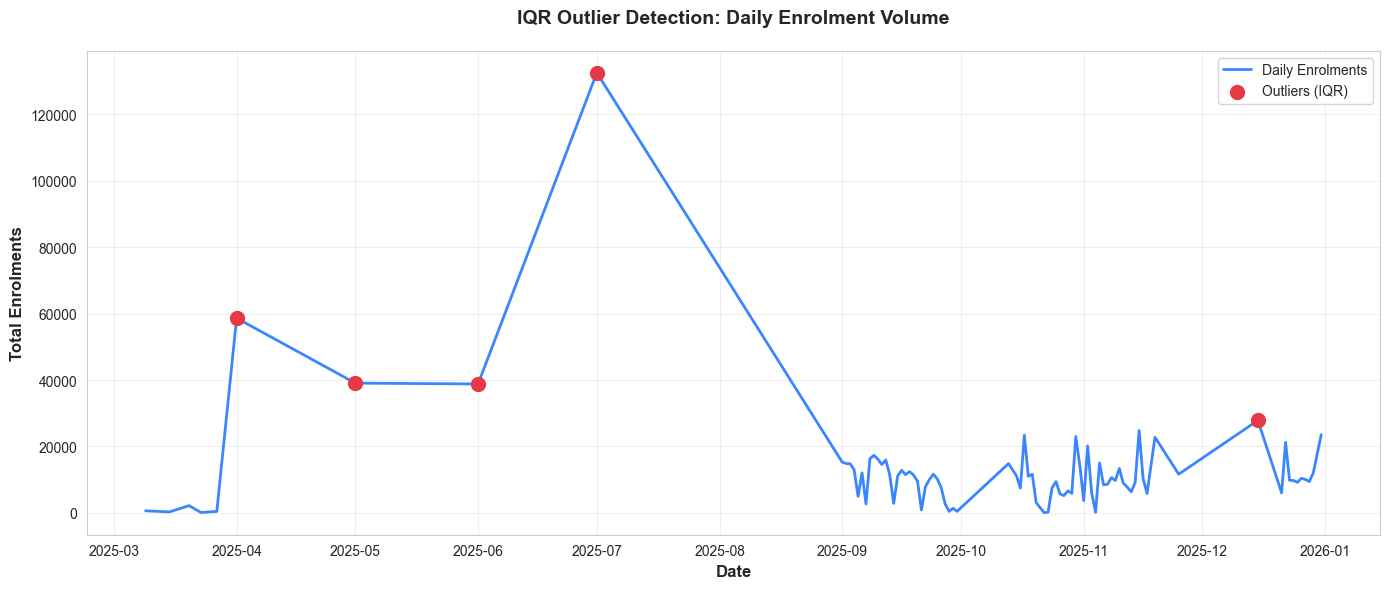

In [3]:
# Prepare daily aggregation
daily_enrol = enrolment_df.groupby('date')['total_enrolments'].sum().reset_index()

# Detect outliers using IQR
daily_with_outliers = detector.detect_statistical_outliers(
    daily_enrol,
    'total_enrolments',
    method='iqr',
    threshold=1.5
)

print(f"=== IQR OUTLIER DETECTION ===\n")
print(f"Total days: {len(daily_enrol)}")
n_outliers = daily_with_outliers['is_outlier'].sum()
print(f"Outliers detected: {n_outliers}")
print(f"Outlier percentage: {n_outliers/len(daily_enrol)*100:.2f}%")

# Mark outliers in dataframe
daily_enrol['is_outlier_iqr'] = daily_with_outliers['is_outlier']
outlier_days = daily_enrol[daily_enrol['is_outlier_iqr']]

print(f"\nOutlier dates:")
for idx, row in outlier_days.iterrows():
    print(f"  {row['date'].strftime('%Y-%m-%d')}: {row['total_enrolments']:,.0f} enrolments")

# Visualization
fig, ax = plt.subplots(figsize=(14, 6))

ax.plot(daily_enrol['date'], daily_enrol['total_enrolments'], 
        color='#3A86FF', linewidth=2, label='Daily Enrolments')

# Highlight outliers
if len(outlier_days) > 0:
    ax.scatter(outlier_days['date'], outlier_days['total_enrolments'],
              color='#E63946', s=100, marker='o', label='Outliers (IQR)', zorder=3)

ax.set_xlabel('Date', fontweight='bold', fontsize=12)
ax.set_ylabel('Total Enrolments', fontweight='bold', fontsize=12)
ax.set_title('IQR Outlier Detection: Daily Enrolment Volume', 
             fontweight='bold', fontsize=14, pad=20)
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../outputs/figures/23_iqr_outliers.png', 
            dpi=300, bbox_inches='tight')
plt.show()

### 2.2 Z-Score Method

In [4]:
# Z-score detection
daily_with_zscore = detector.detect_statistical_outliers(
    daily_enrol,
    'total_enrolments',
    method='zscore',
    threshold=3.0
)

print(f"=== Z-SCORE OUTLIER DETECTION ===\n")
print(f"Threshold: ±3 standard deviations")
n_outliers_z = daily_with_zscore['is_outlier'].sum()
print(f"Outliers detected: {n_outliers_z}")
print(f"Outlier percentage: {n_outliers_z/len(daily_enrol)*100:.2f}%")

daily_enrol['is_outlier_zscore'] = daily_with_zscore['is_outlier']
outlier_days_z = daily_enrol[daily_enrol['is_outlier_zscore']]

print(f"\nOutlier dates (Z-score > 3):")
for idx, row in outlier_days_z.iterrows():
    print(f"  {row['date'].strftime('%Y-%m-%d')}: {row['total_enrolments']:,.0f}")

=== Z-SCORE OUTLIER DETECTION ===

Threshold: ±3 standard deviations
Outliers detected: 1
Outlier percentage: 1.14%

Outlier dates (Z-score > 3):
  2025-07-01: 132,479


### 2.3 Modified Z-Score (Robust)

=== MODIFIED Z-SCORE OUTLIER DETECTION ===

Threshold: ±3.5 (robust method using median)
Outliers detected: 4
Outlier percentage: 4.55%

=== METHOD COMPARISON ===

          Method  Outliers  Percentage
             IQR         5    5.681818
         Z-Score         1    1.136364
Modified Z-Score         4    4.545455


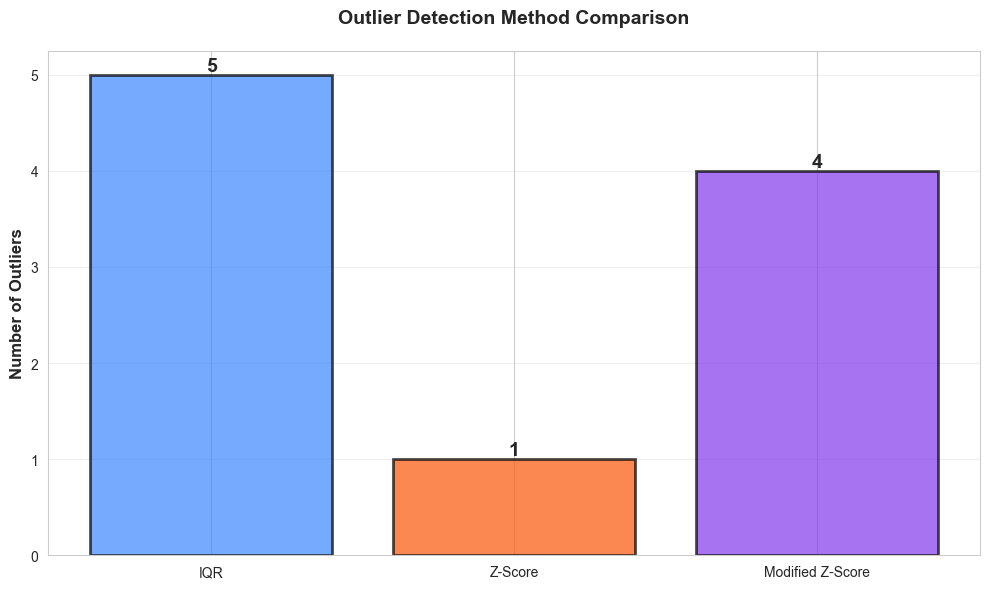

In [5]:
# Modified Z-score (uses median instead of mean)
daily_with_mod_z = detector.detect_statistical_outliers(
    daily_enrol,
    'total_enrolments',
    method='modified_zscore',
    threshold=3.5
)

print(f"=== MODIFIED Z-SCORE OUTLIER DETECTION ===\n")
print(f"Threshold: ±3.5 (robust method using median)")
n_outliers_mod = daily_with_mod_z['is_outlier'].sum()
print(f"Outliers detected: {n_outliers_mod}")
print(f"Outlier percentage: {n_outliers_mod/len(daily_enrol)*100:.2f}%")

daily_enrol['is_outlier_mod_z'] = daily_with_mod_z['is_outlier']

# Compare all three methods
n_outliers_iqr = daily_with_outliers['is_outlier'].sum()
n_outliers_z = daily_with_zscore['is_outlier'].sum()

comparison = pd.DataFrame({
    'Method': ['IQR', 'Z-Score', 'Modified Z-Score'],
    'Outliers': [n_outliers_iqr, n_outliers_z, n_outliers_mod],
    'Percentage': [n_outliers_iqr/len(daily_enrol)*100, 
                   n_outliers_z/len(daily_enrol)*100, 
                   n_outliers_mod/len(daily_enrol)*100]
})

print("\n=== METHOD COMPARISON ===\n")
print(comparison.to_string(index=False))

# Visualization
fig, ax = plt.subplots(figsize=(10, 6))

methods = comparison['Method']
counts = comparison['Outliers']
colors = ['#3A86FF', '#FB5607', '#8338EC']

bars = ax.bar(methods, counts, color=colors, alpha=0.7, edgecolor='black', linewidth=2)

for bar, count in zip(bars, counts):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(count)}',
            ha='center', va='bottom', fontweight='bold', fontsize=14)

ax.set_ylabel('Number of Outliers', fontweight='bold', fontsize=12)
ax.set_title('Outlier Detection Method Comparison', 
             fontweight='bold', fontsize=14, pad=20)
ax.grid(True, axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('../outputs/figures/24_outlier_method_comparison.png', 
            dpi=300, bbox_inches='tight')
plt.show()

## 3. TEMPORAL ANOMALY DETECTION

### 3.1 Weekly Aggregation Anomalies

=== TEMPORAL ANOMALY DETECTION ===

Window size: 7 days (weekly)
Threshold: 2.0 standard deviations
Anomalies detected: 4
Anomaly percentage: 4.55%

Temporal anomalies:
  2025-07-01: 132,479 enrolments
  2025-09-14: 2,862 enrolments
  2025-09-21: 879 enrolments
  2025-11-15: 24,800 enrolments


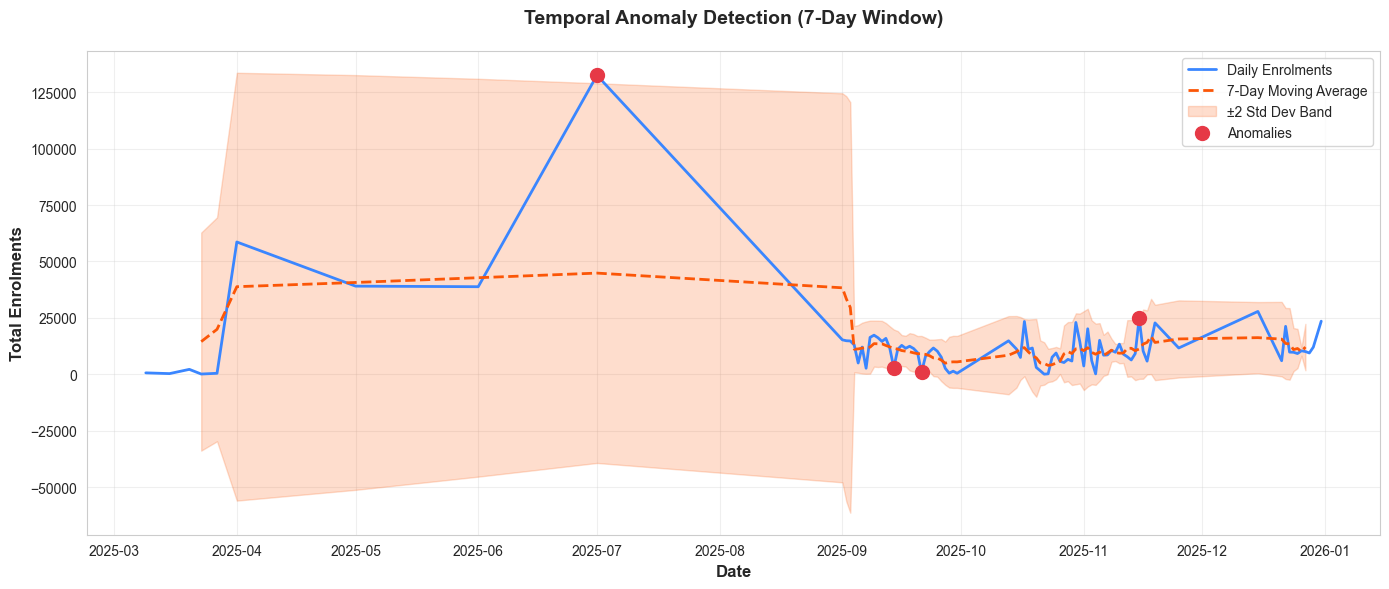

In [6]:
# Detect temporal anomalies
temporal_results = detector.detect_temporal_anomalies(
    daily_enrol,
    'date',
    'total_enrolments',
    window=7,
    threshold=2.0
)

print(f"=== TEMPORAL ANOMALY DETECTION ===\n")
print(f"Window size: 7 days (weekly)")
print(f"Threshold: 2.0 standard deviations")
n_anomalies = temporal_results['is_anomaly'].sum()
print(f"Anomalies detected: {n_anomalies}")
print(f"Anomaly percentage: {n_anomalies/len(temporal_results)*100:.2f}%")

# Show anomaly dates
anomalies = temporal_results[temporal_results['is_anomaly']]
print(f"\nTemporal anomalies:")
for idx, row in anomalies.head(10).iterrows():
    print(f"  {row['date'].strftime('%Y-%m-%d')}: {row['total_enrolments']:,.0f} enrolments")

# Visualization
fig, ax = plt.subplots(figsize=(14, 6))

ax.plot(temporal_results['date'], temporal_results['total_enrolments'], 
        color='#3A86FF', linewidth=2, label='Daily Enrolments')

# Plot rolling mean and std bands
ax.plot(temporal_results['date'], temporal_results['moving_mean'], 
        color='#FB5607', linewidth=2, linestyle='--', label='7-Day Moving Average')

# Upper/lower bounds
ax.fill_between(temporal_results['date'], 
                temporal_results['lower_bound'], 
                temporal_results['upper_bound'], 
                alpha=0.2, color='#FB5607', label='±2 Std Dev Band')

# Highlight anomalies
if len(anomalies) > 0:
    ax.scatter(anomalies['date'], anomalies['total_enrolments'],
              color='#E63946', s=100, marker='o', label='Anomalies', zorder=3)

ax.set_xlabel('Date', fontweight='bold', fontsize=12)
ax.set_ylabel('Total Enrolments', fontweight='bold', fontsize=12)
ax.set_title('Temporal Anomaly Detection (7-Day Window)', 
             fontweight='bold', fontsize=14, pad=20)
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../outputs/figures/25_temporal_anomalies.png', 
            dpi=300, bbox_inches='tight')
plt.show()

### 3.2 Changepoint Detection

=== CHANGEPOINT DETECTION ===

Minimum segment size: 7 days
Changepoints detected: 4

Changepoint dates:
  2025-07-01T00:00:00.000000000: (value: 132,479)
  2025-09-27T00:00:00.000000000: (value: 2,635)
  2025-10-21T00:00:00.000000000: (value: 1,568)
  2025-10-28T00:00:00.000000000: (value: 6,623)


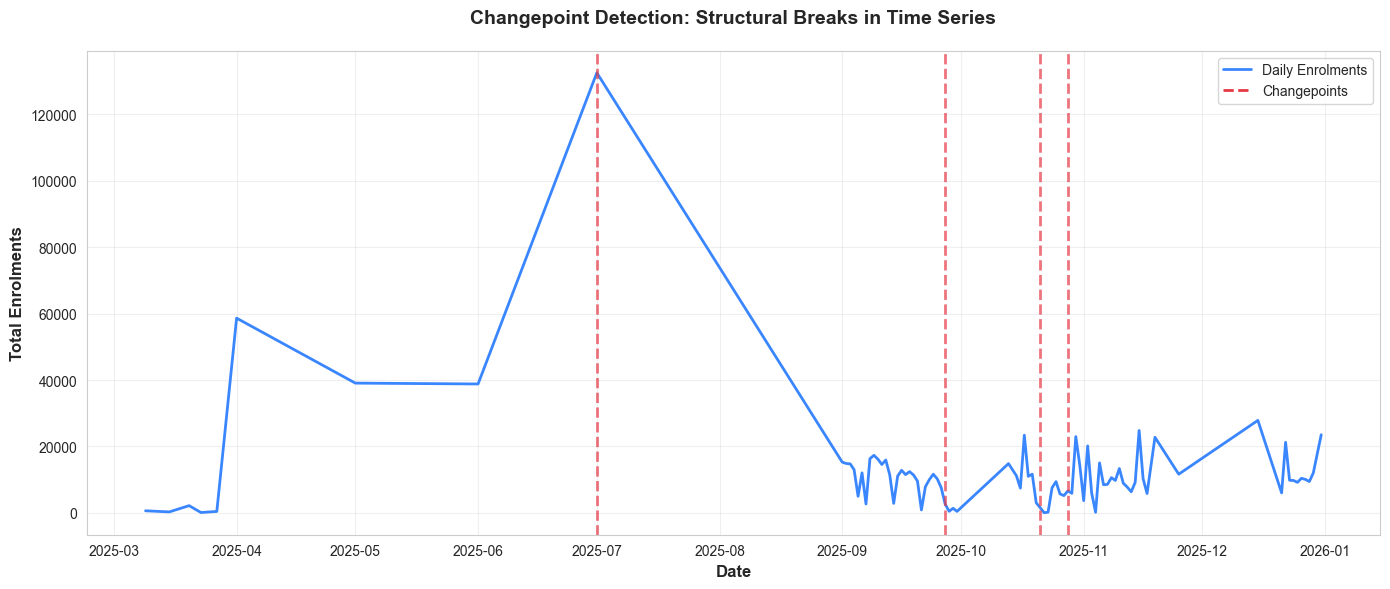

In [7]:
# Detect changepoints
changepoint_dates = detector.detect_changepoints(
    daily_enrol,
    'date',
    'total_enrolments',
    min_size=7
)

print(f"=== CHANGEPOINT DETECTION ===\n")
print(f"Minimum segment size: 7 days")
print(f"Changepoints detected: {len(changepoint_dates)}")

if len(changepoint_dates) > 0:
    print(f"\nChangepoint dates:")
    for cp_date in changepoint_dates:
        cp_value = daily_enrol[daily_enrol['date'] == cp_date]['total_enrolments'].values
        if len(cp_value) > 0:
            print(f"  {cp_date}: (value: {cp_value[0]:,.0f})")

# Visualization
fig, ax = plt.subplots(figsize=(14, 6))

ax.plot(daily_enrol['date'], daily_enrol['total_enrolments'], 
        color='#3A86FF', linewidth=2, label='Daily Enrolments')

# Mark changepoints
if len(changepoint_dates) > 0:
    for cp_date in changepoint_dates:
        ax.axvline(x=cp_date, color='#E63946', 
                  linestyle='--', linewidth=2, alpha=0.7)

ax.set_xlabel('Date', fontweight='bold', fontsize=12)
ax.set_ylabel('Total Enrolments', fontweight='bold', fontsize=12)
ax.set_title('Changepoint Detection: Structural Breaks in Time Series', 
             fontweight='bold', fontsize=14, pad=20)
ax.grid(True, alpha=0.3)

# Add custom legend entry for changepoints
if len(changepoint_dates) > 0:
    from matplotlib.lines import Line2D
    custom_lines = [Line2D([0], [0], color='#3A86FF', linewidth=2),
                   Line2D([0], [0], color='#E63946', linewidth=2, linestyle='--')]
    ax.legend(custom_lines, ['Daily Enrolments', 'Changepoints'])
else:
    ax.legend()

plt.tight_layout()
plt.savefig('../outputs/figures/26_changepoint_detection.png', 
            dpi=300, bbox_inches='tight')
plt.show()

## 4. MACHINE LEARNING-BASED ANOMALY DETECTION

### 4.1 Isolation Forest - Daily Enrolments

=== ISOLATION FOREST ANOMALY DETECTION ===

Contamination parameter: 0.05 (5%)
Anomalies detected: 5
Anomaly percentage: 5.68%

ML-detected anomalies (sorted by score):
  2025-07-01: 132,479 (score: 0.871)
  2025-04-01: 58,620 (score: 0.771)
  2025-05-01: 39,062 (score: 0.649)
  2025-06-01: 38,804 (score: 0.647)
  2025-12-15: 27,844 (score: 0.621)


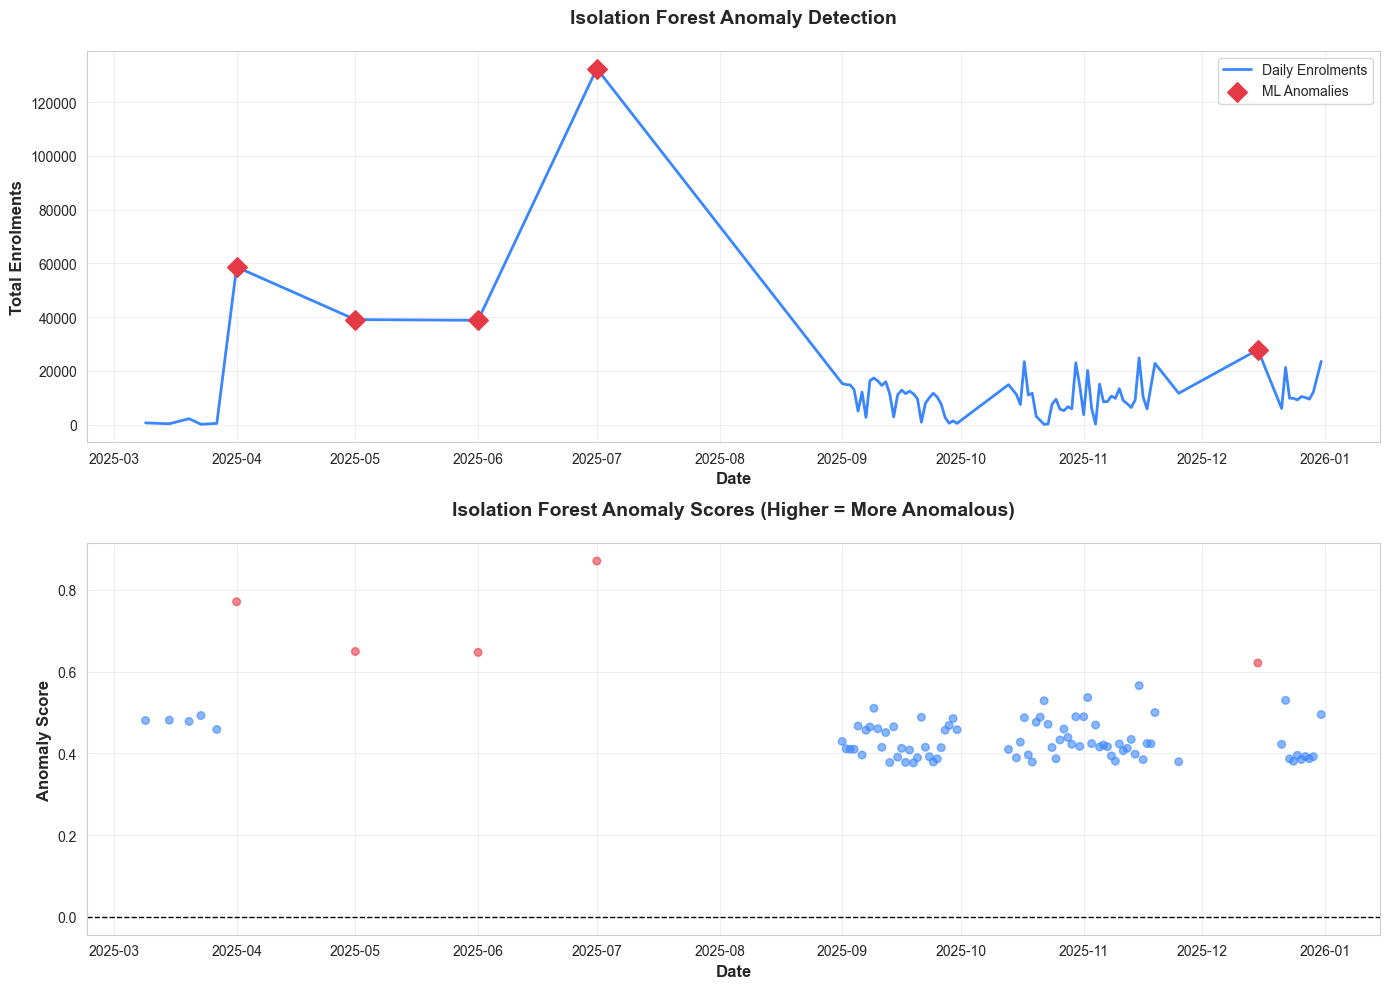

In [8]:
# Prepare features for ML detection
features_df = daily_enrol[['total_enrolments']].copy()

# Apply Isolation Forest
ml_results = detector.detect_multivariate_anomalies(
    daily_enrol,
    ['total_enrolments'],
    contamination=0.05  # Expect 5% anomalies
)

print(f"=== ISOLATION FOREST ANOMALY DETECTION ===\n")
print(f"Contamination parameter: 0.05 (5%)")
n_ml_anomalies = ml_results['is_anomaly_ml'].sum()
print(f"Anomalies detected: {n_ml_anomalies}")
print(f"Anomaly percentage: {n_ml_anomalies/len(ml_results)*100:.2f}%")

daily_enrol['is_anomaly_ml'] = ml_results['is_anomaly_ml']
daily_enrol['anomaly_score'] = ml_results['anomaly_score_ml']

ml_anomalies = daily_enrol[daily_enrol['is_anomaly_ml']]

print(f"\nML-detected anomalies (sorted by score):")
ml_sorted = ml_anomalies.sort_values('anomaly_score', ascending=False)
for idx, row in ml_sorted.head(10).iterrows():
    print(f"  {row['date'].strftime('%Y-%m-%d')}: {row['total_enrolments']:,.0f} "
          f"(score: {row['anomaly_score']:.3f})")

# Visualization
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

# Time series with anomalies
ax1.plot(daily_enrol['date'], daily_enrol['total_enrolments'], 
        color='#3A86FF', linewidth=2, label='Daily Enrolments')

if len(ml_anomalies) > 0:
    ax1.scatter(ml_anomalies['date'], ml_anomalies['total_enrolments'],
               color='#E63946', s=100, marker='D', label='ML Anomalies', zorder=3)

ax1.set_xlabel('Date', fontweight='bold', fontsize=12)
ax1.set_ylabel('Total Enrolments', fontweight='bold', fontsize=12)
ax1.set_title('Isolation Forest Anomaly Detection', 
             fontweight='bold', fontsize=14, pad=20)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Anomaly scores
colors = ['#E63946' if is_anom else '#3A86FF' 
         for is_anom in daily_enrol['is_anomaly_ml']]
ax2.scatter(daily_enrol['date'], daily_enrol['anomaly_score'], 
           c=colors, alpha=0.6, s=30)
ax2.axhline(y=0, color='black', linestyle='--', linewidth=1)
ax2.set_xlabel('Date', fontweight='bold', fontsize=12)
ax2.set_ylabel('Anomaly Score', fontweight='bold', fontsize=12)
ax2.set_title('Isolation Forest Anomaly Scores (Higher = More Anomalous)', 
             fontweight='bold', fontsize=14, pad=20)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../outputs/figures/27_isolation_forest_anomalies.png', 
            dpi=300, bbox_inches='tight')
plt.show()

### 4.2 Multi-Feature Isolation Forest

In [9]:
# Prepare multi-dimensional features
state_daily = enrolment_df.groupby(['date', 'state'])['total_enrolments'].sum().reset_index()
state_pivot = state_daily.pivot(index='date', columns='state', values='total_enrolments').fillna(0)

# Use top 10 states as features
top_10_states = enrolment_df.groupby('state')['total_enrolments'].sum().nlargest(10).index.tolist()
multi_feature_df = state_pivot[top_10_states].reset_index()

print(f"=== MULTI-FEATURE ANOMALY DETECTION ===\n")
print(f"Feature dimensions: {len(multi_feature_df)} days × {len(top_10_states)} states")
print(f"Features: Top 10 states' daily enrolments")

# Apply Isolation Forest
multi_results = detector.detect_multivariate_anomalies(
    multi_feature_df,
    top_10_states,
    contamination=0.05
)

print(f"\nAnomalies detected: {multi_results['is_anomaly_ml'].sum()}")
print(f"Anomaly percentage: {multi_results['is_anomaly_ml'].sum()/len(multi_results)*100:.2f}%")

# Add results to dataframe
multi_results['date'] = multi_feature_df['date']
multi_anomalies = multi_results[multi_results['is_anomaly_ml']]

print(f"\nMulti-feature anomaly dates:")
for idx, row in multi_anomalies.head(10).iterrows():
    print(f"  {row['date'].strftime('%Y-%m-%d')}: score = {row['anomaly_score_ml']:.3f}")

=== MULTI-FEATURE ANOMALY DETECTION ===

Feature dimensions: 88 days × 10 states
Features: Top 10 states' daily enrolments

Anomalies detected: 5
Anomaly percentage: 5.68%

Multi-feature anomaly dates:
  2025-04-01: score = 0.740
  2025-05-01: score = 0.690
  2025-06-01: score = 0.666
  2025-07-01: score = 0.850
  2025-12-15: score = 0.603


## 5. GEOGRAPHIC ANOMALY PATTERNS

### 5.1 State-Level Anomalies

=== GEOGRAPHIC ANOMALIES (State Level) ===

Total states: 48
Anomalous states: 6
Outlier percentage: 12.50%

Outlier states (exceptionally high or low):
  Uttar Pradesh                 :    204,774
  Bihar                         :    120,312
  Madhya Pradesh                :    101,233
  West Bengal                   :     76,976
  Maharashtra                   :     73,973
  Rajasthan                     :     68,572


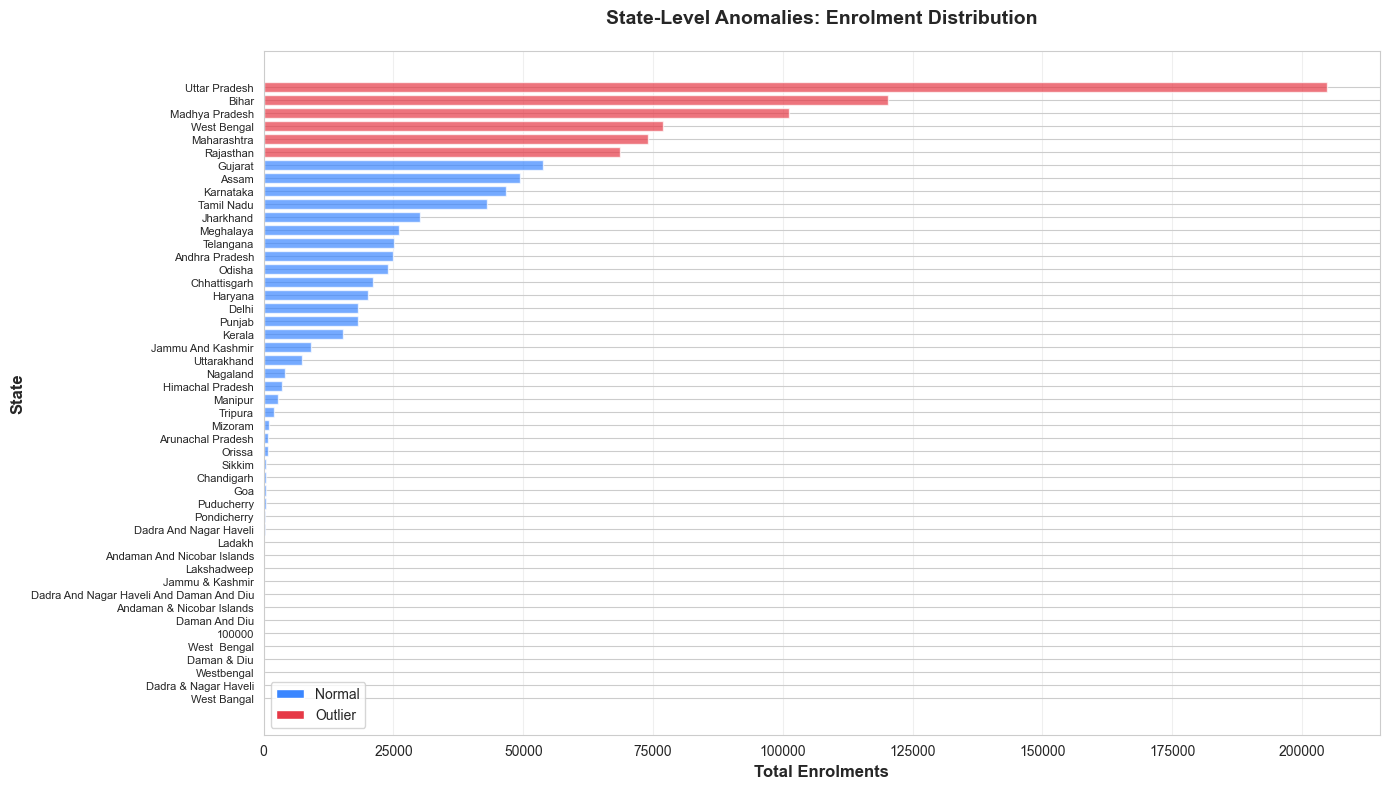

In [10]:
# Calculate state totals
state_totals = enrolment_df.groupby('state')['total_enrolments'].sum().reset_index()

# Detect state-level outliers
state_with_outliers = detector.detect_statistical_outliers(
    state_totals,
    'total_enrolments',
    method='iqr',
    threshold=1.5
)

print(f"=== GEOGRAPHIC ANOMALIES (State Level) ===\n")
print(f"Total states: {len(state_totals)}")
n_outlier_states = state_with_outliers['is_outlier'].sum()
print(f"Anomalous states: {n_outlier_states}")
print(f"Outlier percentage: {n_outlier_states/len(state_totals)*100:.2f}%")

state_totals['is_outlier'] = state_with_outliers['is_outlier']
outlier_states = state_totals[state_totals['is_outlier']].sort_values('total_enrolments', ascending=False)

print(f"\nOutlier states (exceptionally high or low):")
for idx, row in outlier_states.iterrows():
    print(f"  {row['state']:30s}: {row['total_enrolments']:10,.0f}")

# Visualization
fig, ax = plt.subplots(figsize=(14, 8))

colors = ['#E63946' if outlier else '#3A86FF' for outlier in state_totals['is_outlier']]
sorted_states = state_totals.sort_values('total_enrolments', ascending=True)

bars = ax.barh(range(len(sorted_states)), sorted_states['total_enrolments'], 
              color=['#E63946' if o else '#3A86FF' for o in sorted_states['is_outlier']], 
              alpha=0.7)
ax.set_yticks(range(len(sorted_states)))
ax.set_yticklabels(sorted_states['state'], fontsize=8)
ax.set_xlabel('Total Enrolments', fontweight='bold', fontsize=12)
ax.set_ylabel('State', fontweight='bold', fontsize=12)
ax.set_title('State-Level Anomalies: Enrolment Distribution', 
             fontweight='bold', fontsize=14, pad=20)
ax.grid(True, axis='x', alpha=0.3)

# Add legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='#3A86FF', label='Normal'),
                   Patch(facecolor='#E63946', label='Outlier')]
ax.legend(handles=legend_elements)

plt.tight_layout()
plt.savefig('../outputs/figures/28_geographic_anomalies.png', 
            dpi=300, bbox_inches='tight')
plt.show()

### 5.2 District-Level Anomalies

In [11]:
# District totals
district_totals = enrolment_df.groupby('district')['total_enrolments'].sum().reset_index()

# Detect district-level outliers
district_with_outliers = detector.detect_statistical_outliers(
    district_totals,
    'total_enrolments',
    method='iqr',
    threshold=1.5
)

print(f"=== GEOGRAPHIC ANOMALIES (District Level) ===\n")
print(f"Total districts: {len(district_totals)}")
n_district_outliers = district_with_outliers['is_outlier'].sum()
print(f"Anomalous districts: {n_district_outliers}")
print(f"Outlier percentage: {n_district_outliers/len(district_totals)*100:.2f}%")

district_totals['is_outlier'] = district_with_outliers['is_outlier']
outlier_districts = district_totals[district_totals['is_outlier']].sort_values(
    'total_enrolments', ascending=False)

print(f"\nTop 20 outlier districts:")
for idx, row in outlier_districts.head(20).iterrows():
    print(f"  {row['district']:30s}: {row['total_enrolments']:10,.0f}")

=== GEOGRAPHIC ANOMALIES (District Level) ===

Total districts: 922
Anomalous districts: 55
Outlier percentage: 5.97%

Top 20 outlier districts:
  Thane                         :      9,141
  Moradabad                     :      8,668
  Aligarh                       :      7,689
  Bengaluru                     :      7,534
  Murshidabad                   :      7,354
  Lucknow                       :      7,325
  Agra                          :      7,253
  Bahraich                      :      7,089
  Sitamarhi                     :      6,985
  East Khasi Hills              :      6,868
  Pashchim Champaran            :      6,857
  Barwani                       :      6,776
  Shahjahanpur                  :      6,685
  Alwar                         :      6,654
  Jaipur                        :      6,444
  South 24 Parganas             :      6,347
  East Champaran                :      6,234
  Pune                          :      6,152
  Muzaffarpur                   :      5,995


## 6. ANOMALY SUMMARY & INSIGHTS

In [12]:
print("="*80)
print("ANOMALY DETECTION - KEY FINDINGS")
print("="*80)

print("\n📊 STATISTICAL OUTLIERS (Daily Enrolments):")
print(f"  • IQR method: {n_outliers} outliers ({n_outliers/len(daily_enrol)*100:.2f}%)")
print(f"  • Z-score method: {n_outliers_z} outliers ({n_outliers_z/len(daily_enrol)*100:.2f}%)")
print(f"  • Modified Z-score: {n_outliers_mod} outliers ({n_outliers_mod/len(daily_enrol)*100:.2f}%)")

print("\n🕒 TEMPORAL ANOMALIES:")
print(f"  • Rolling window anomalies: {n_anomalies}")
print(f"  • Changepoints detected: {len(changepoint_dates)}")

print("\n🤖 MACHINE LEARNING DETECTION:")
print(f"  • Isolation Forest (univariate): {n_ml_anomalies} anomalies")
print(f"  • Isolation Forest (multi-feature): {multi_results['is_anomaly_ml'].sum()} anomalies")

print("\n🗺️  GEOGRAPHIC ANOMALIES:")
print(f"  • State-level outliers: {n_outlier_states} states")
print(f"  • District-level outliers: {n_district_outliers} districts")

print("\n💡 KEY INSIGHTS:")
print("  • Statistical methods provide baseline outlier detection")
print("  • ML-based methods capture complex, multi-dimensional patterns")
print("  • Temporal anomalies reveal unusual activity periods")
print("  • Geographic outliers highlight states/districts with exceptional volumes")
print("  • Changepoints indicate structural shifts in enrolment patterns")

print("\n✓ Anomaly detection analysis completed successfully")
print("="*80)

ANOMALY DETECTION - KEY FINDINGS

📊 STATISTICAL OUTLIERS (Daily Enrolments):
  • IQR method: 5 outliers (5.68%)
  • Z-score method: 1 outliers (1.14%)
  • Modified Z-score: 4 outliers (4.55%)

🕒 TEMPORAL ANOMALIES:
  • Rolling window anomalies: 4
  • Changepoints detected: 4

🤖 MACHINE LEARNING DETECTION:
  • Isolation Forest (univariate): 5 anomalies
  • Isolation Forest (multi-feature): 5 anomalies

🗺️  GEOGRAPHIC ANOMALIES:
  • State-level outliers: 6 states
  • District-level outliers: 55 districts

💡 KEY INSIGHTS:
  • Statistical methods provide baseline outlier detection
  • ML-based methods capture complex, multi-dimensional patterns
  • Temporal anomalies reveal unusual activity periods
  • Geographic outliers highlight states/districts with exceptional volumes
  • Changepoints indicate structural shifts in enrolment patterns

✓ Anomaly detection analysis completed successfully
